In [90]:
# !pip install recmetrics
from sklearn.model_selection import train_test_split
from networkx.algorithms import bipartite
from tqdm import tqdm
import matplotlib.pyplot as plt
import recmetrics
import pandas as pd
import networkx as nx
import numpy as np
import os
from sklearn import preprocessing as pp

# PageRank

In [12]:
class PersonalizedPageRankRecSys:
    def __init__(self, user_movie_graph, movie_movie_graph, movies):
        self.user_movie_graph = user_movie_graph
        self.movie_movie_graph = movie_movie_graph
        self.movies = movies

    def create_preference_vector(self, user_id):
        if user_id not in self.user_movie_graph.nodes():
            return None

        edges = {m: w for _, m, w in self.user_movie_graph.edges(user_id, data="weight")}
        total = sum(edges.values())

        if total > 0:
            return {movie: edges.get(movie, 0) / total for movie in self.movies}
        else:
            return {movie: 1 for movie in self.movies}

    def recommend(self, user_id):
        p_vec = self.create_preference_vector(user_id)

        if p_vec is None:
            pr = nx.pagerank(self.movie_movie_graph)
        else:
            pr = nx.pagerank(self.movie_movie_graph, personalization=p_vec)

        sorted_nodes = sorted(pr.items(), key=lambda x: x[1], reverse=True)

        if p_vec is None:
            recommended_nodes = [(node, score) for node, score in sorted_nodes]
        else:
            recommended_nodes = [(node, score) for node, score in sorted_nodes if node not in self.user_movie_graph[user_id]]

        return recommended_nodes



def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.

    This function computes the average prescision at k between two lists of
    items.

    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements

    Returns
    -------
    score : double
            The average precision at k over the input lists

    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.

    This function computes the mean average prescision at k between two lists
    of lists of items.

    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements

    Returns
    -------
    score : double
            The mean average precision at k over the input lists

    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

In [93]:
#a list of tuples, where each tuple contains the name of the dataset and the paths to the train and test datasets
datasets = [
    ('movie_lens', '../data_source/movie_lens/movie_lens_train.csv', '../data_source/movie_lens/movie_lens_test.csv'),
    ('beer_ratings', '../data_source/beer_ratings/beer_ratings_train.csv', '../data_source/beer_ratings/beer_ratings_test.csv')
#     ('bank_products', '../data_source/bank_products/bank_products_train.csv', '../data_source/bank_products/bank_products_test.csv')
]

In [94]:
all_MAP = []
all_MAR = []

Running code for movie_lens dataset...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [19:09<00:00, 11.50s/it]


Running code for beer_ratings dataset...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [06:57<00:00,  4.18s/it]


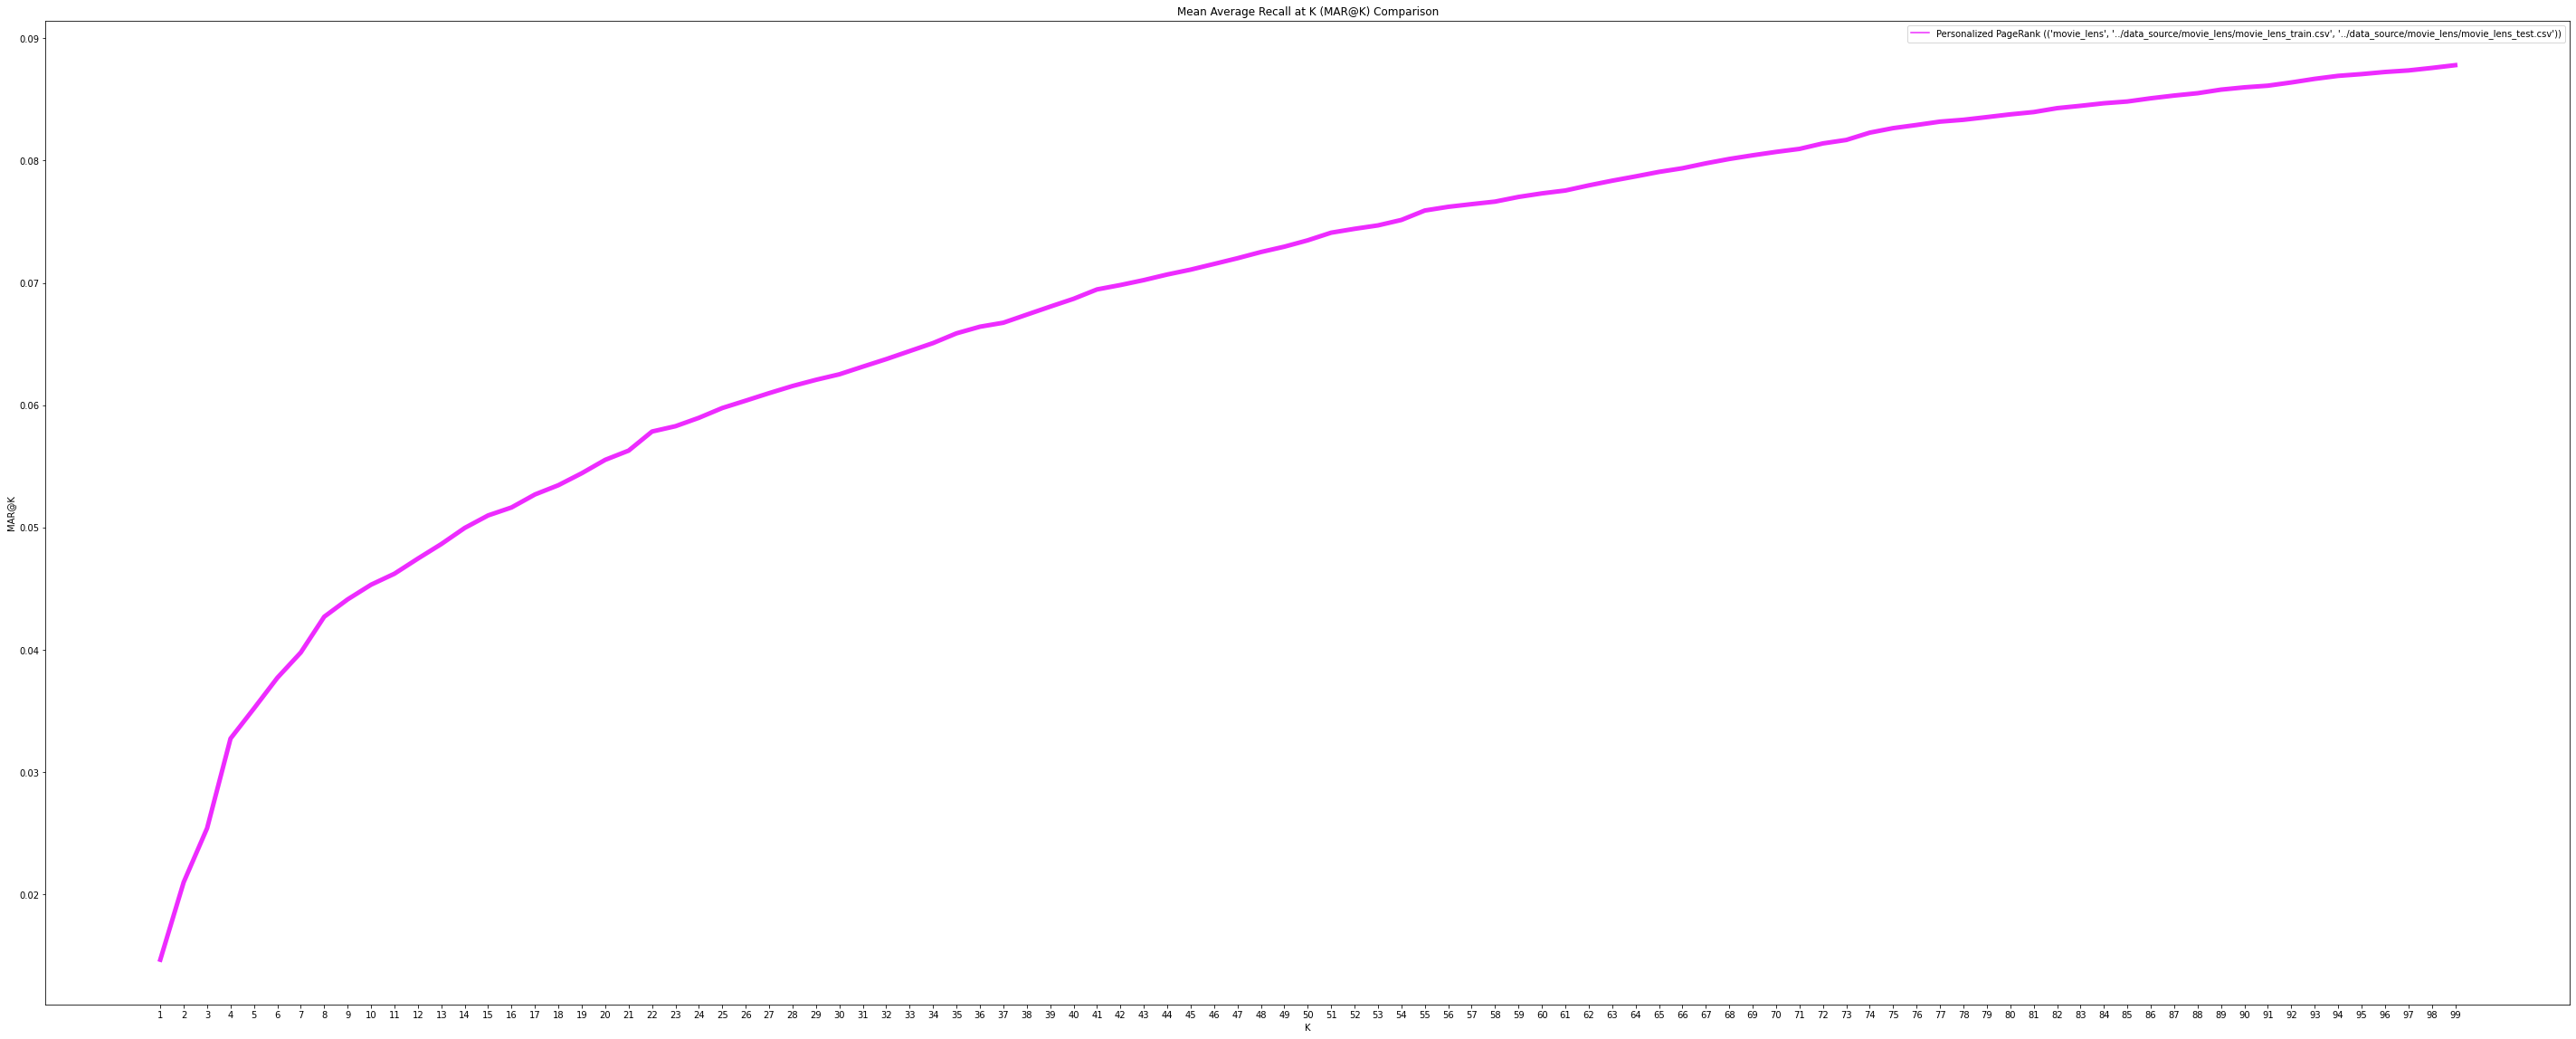

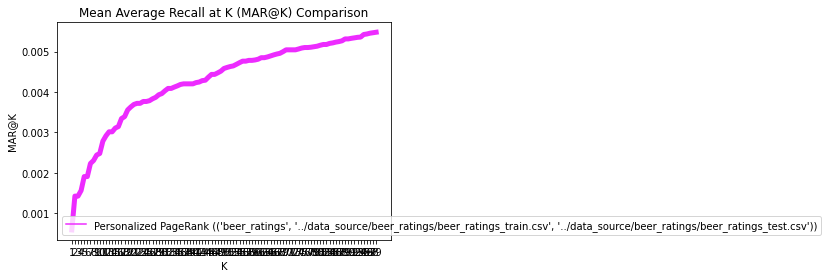

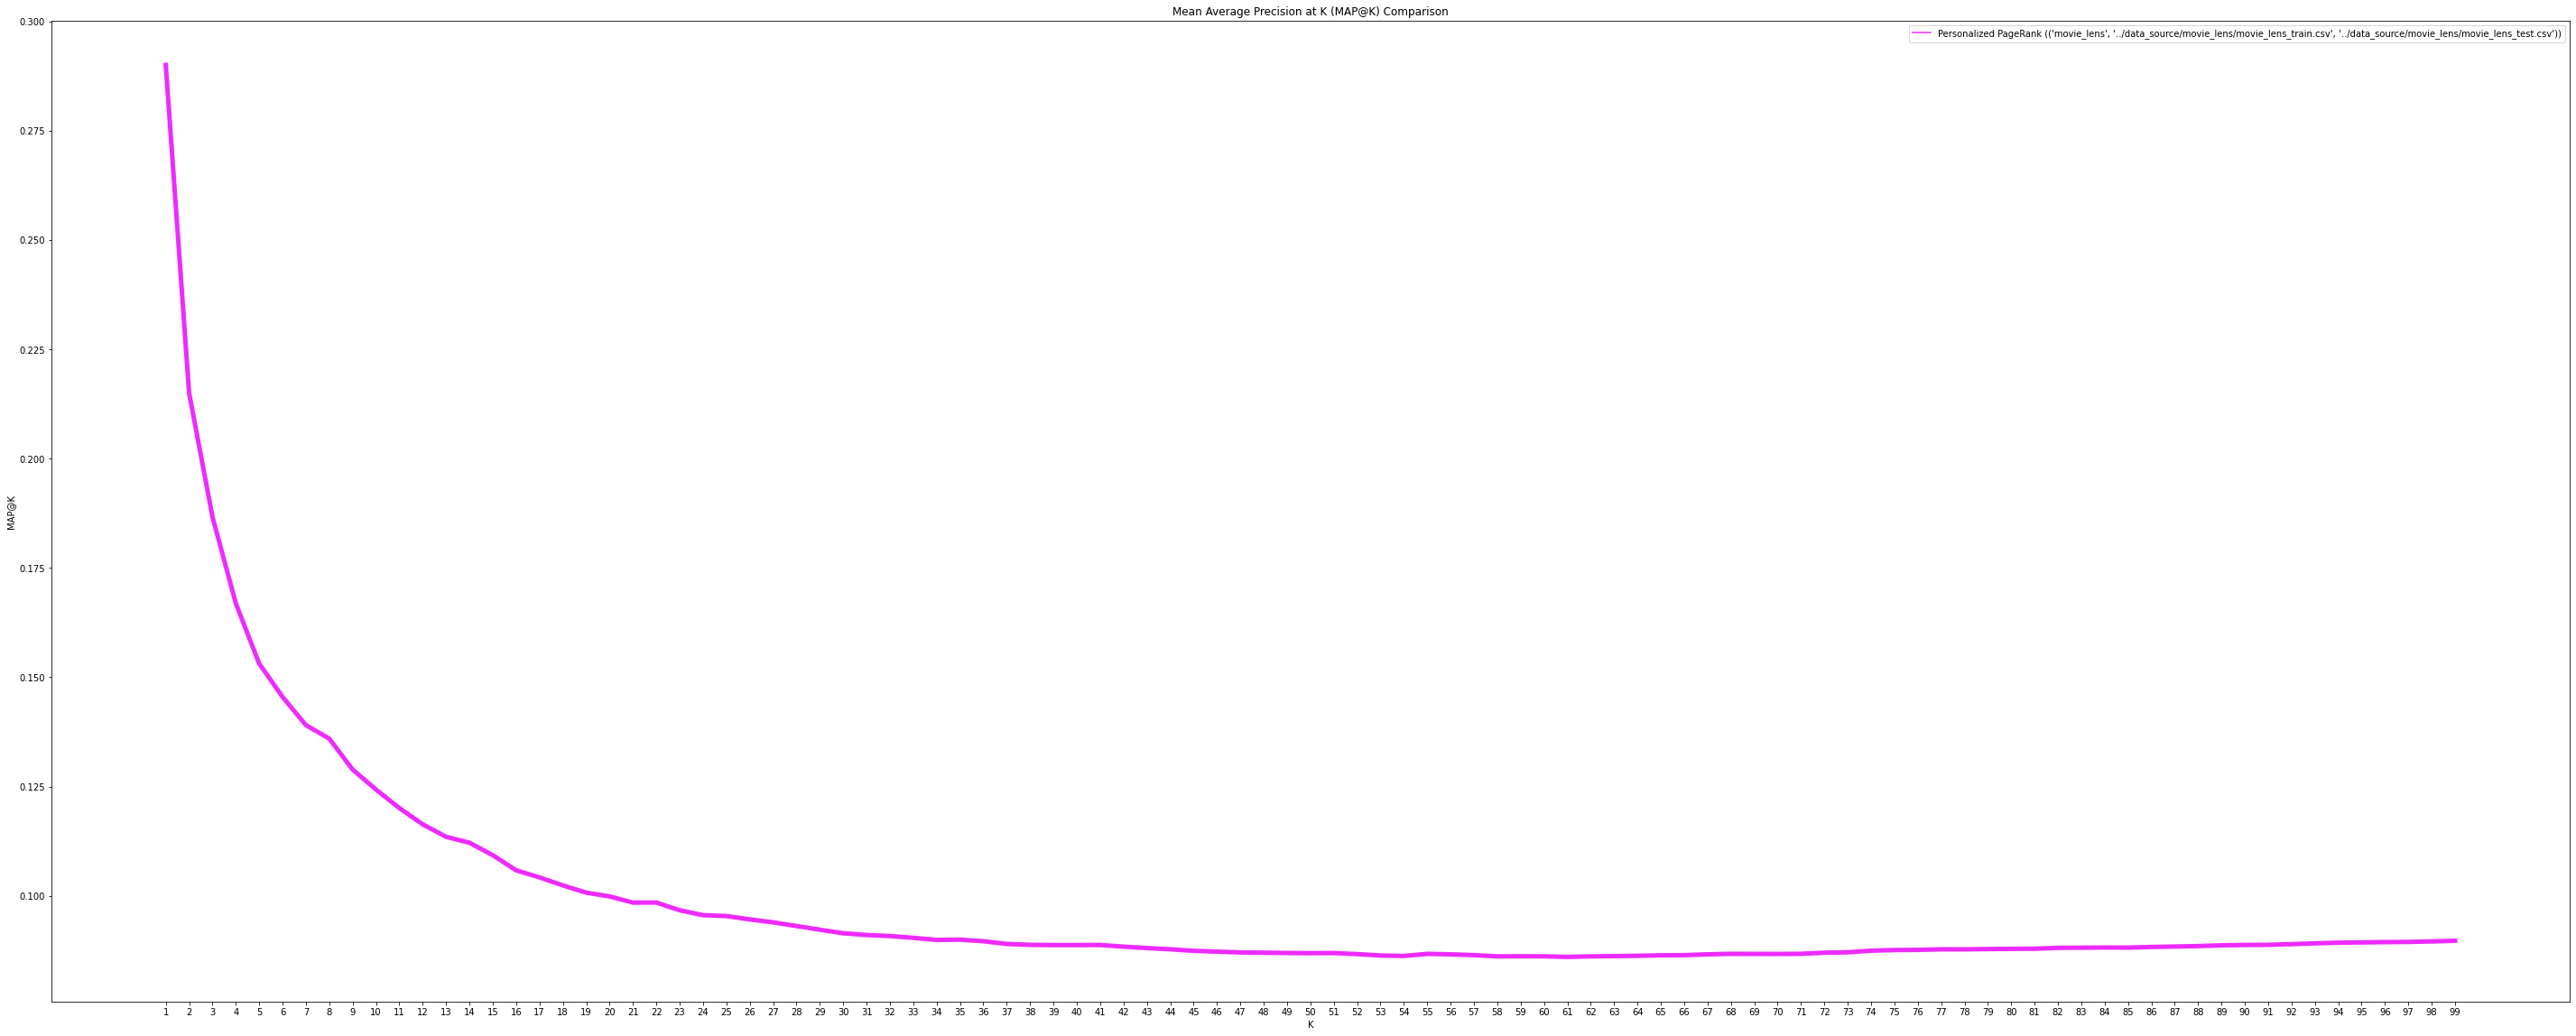

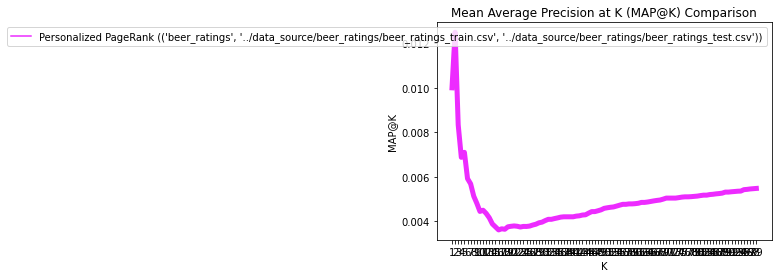

In [95]:
for dataset_name, train_path, test_path in datasets:
    print(f"Running code for {dataset_name} dataset...")

    #reading train and test datasets
    train = pd.read_csv(train_path)
    test = pd.read_csv(test_path)

    #renaming columns in train and test datasets to run code evenly 
    train = train.rename(columns={col: 'user_id' if 'user' in col.lower() else 'item_id' if col.lower().endswith('_id') and not col.lower().startswith('user') else col for col in train.columns})
    test = test.rename(columns={col: 'user_id' if 'user' in col.lower() else 'item_id' if col.lower().endswith('_id') and not col.lower().startswith('user') else col for col in test.columns})
    
    if dataset_name == 'beer_ratings':
        user_encoder = pp.LabelEncoder()
        user_encoder.fit(np.concatenate([train['user_id'].values, test['user_id'].values]))
        train['user_id'] = user_encoder.transform(train['user_id'].values)
        test['user_id'] = user_encoder.transform(test['user_id'].values)

    
    edges = []
    users = set()
    items = set()
    for index, row in train.iterrows():
        #to avoid users intersection, creatinf a shift in users_id
        user, item = row["user_id"] + 1000000, row["item_id"]
        edges.append((user, item, row["rating"]))
        users.add(user)
        items.add(item)


    user_graph_train = nx.Graph()
    user_graph_train.add_nodes_from(list(users) + list(items))
    user_graph_train.add_weighted_edges_from(edges)
    item_item_graph_train = bipartite.weighted_projected_graph(user_graph_train, list(items), ratio=True)
    
    recsys = PersonalizedPageRankRecSys(user_graph_train, item_item_graph_train, items)
    
    #creating a set of unique users from the test data
    users_in_test = set(test["user_id"] + 1000000)

    #users_movies_test dictionary
    users_test = dict()
    for index, row in test.iterrows():
        user, item = row["user_id"] + 1000000, row["item_id"]
        if user in users_test:
            users_test[user].append(item)
        else:
            users_test[user] = [item]

    #create users_to_predict list from the users in the test data for the first 100 users
    if dataset_name == 'beer_ratings':
        users_to_predict = [user + 1000000 for user in train["user_id"].value_counts().index.tolist() if user + 1000000 in list(users_test.keys())][:100]
    else:
        users_to_predict = list(users_in_test)[:100]

    users_pred = dict()
    for user in tqdm(users_to_predict):
        users_pred[user] = recsys.recommend(user)[:100]
        
    MAP = []
    MAR = []

    for k in range(1, 100):
        y_true = []
        y_pred = []
        for user in users_to_predict:
            true = users_test[user]
            pred = [p[0] for p in users_pred[user]][:k]

            y_true.append(true)
            y_pred.append(pred)

        MAR.append(recmetrics.mark(y_true, y_pred, k = k))
        MAP.append(mapk(y_true, y_pred, k = k))

    all_MAP.append(MAP)
    all_MAR.append(MAR)

plt.figure(figsize=(50, 20))
for i, dataset_name in enumerate(datasets):
    recmetrics.mark_plot([all_MAR[i]], [f"Personalized PageRank ({dataset_name})"], range(1, 100))

plt.figure(figsize=(50, 20))
for i, dataset_name in enumerate(datasets):
    recmetrics.mapk_plot([all_MAP[i]], [f"Personalized PageRank ({dataset_name})"], range(1, 100))

## LightGCN

In [ ]:
import random
import time

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_geometric
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import degree

from tqdm.notebook import tqdm
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
import scipy.sparse as sp

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

In [ ]:
###currently working on optimizing code from draft_notebooks folder